In [53]:
library(stats)
library(graphics)
library(grDevices)
install.packages("randomForest")
library(randomForest)
install.packages("rpart")
library(rpart)

Warning message:
Warning message:Forest' is not available (for R version 3.6.1)"
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/3.6:
Warning message: abrir la URL 'https://cran.r-project.org/bin/windows/contrib/3.6/PACKAGES'"
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/3.6:
Package which is only available in source form, and may needn/windows/contrib/3.6/PACKAGES'"
  compilation of C/C++/Fortran: 'rpart'


  These will not be installed


In [61]:
# Cargar datos limpios (construidos previamente en el código de python)
df <- read.csv("C:/Decision_Trees/R/input/cleaned_cleveland_data.csv", header = TRUE)
print(head(df))

  age sex cp restbp chol fbs restecg thalach exang oldpeak slope  ca thal hd
1  63   1  1    145  233   1       2     150     0     2.3     3 0.0  6.0  0
2  67   1  4    160  286   0       2     108     1     1.5     2 3.0  3.0  2
3  67   1  4    120  229   0       2     129     1     2.6     2 2.0  7.0  1
4  37   1  3    130  250   0       0     187     0     3.5     3 0.0  3.0  0
5  41   0  2    130  204   0       2     172     0     1.4     1 0.0  3.0  0
6  56   1  2    120  236   0       0     178     0     0.8     1 0.0  3.0  0


In [62]:
# Crear variable de tratamiento con asignación aleatoria
set.seed(123)
df$T <- rbinom(nrow(df), size = 1, prob = 0.5)
print(head(df))

  age sex cp restbp chol fbs restecg thalach exang oldpeak slope  ca thal hd T
1  63   1  1    145  233   1       2     150     0     2.3     3 0.0  6.0  0 0
2  67   1  4    160  286   0       2     108     1     1.5     2 3.0  3.0  2 1
3  67   1  4    120  229   0       2     129     1     2.6     2 2.0  7.0  1 0
4  37   1  3    130  250   0       0     187     0     3.5     3 0.0  3.0  0 1
5  41   0  2    130  204   0       2     172     0     1.4     1 0.0  3.0  0 1
6  56   1  2    120  236   0       0     178     0     0.8     1 0.0  3.0  0 0


In [63]:
# Crear variable de resultado Y que muestre el efecto del tratamiento más otras covariables y ruido
set.seed(123)
epsilon <- rnorm(nrow(df), mean = 0, sd = 1)

# Crear Y
df$Y <- (1 + 0.05*df$age + 0.3*df$sex + 0.2*df$restbp) * df$T + 
        0.5*df$oldpeak + 
        epsilon

print(head(df))

  age sex cp restbp chol fbs restecg thalach exang oldpeak slope  ca thal hd T
1  63   1  1    145  233   1       2     150     0     2.3     3 0.0  6.0  0 0
2  67   1  4    160  286   0       2     108     1     1.5     2 3.0  3.0  2 1
3  67   1  4    120  229   0       2     129     1     2.6     2 2.0  7.0  1 0
4  37   1  3    130  250   0       0     187     0     3.5     3 0.0  3.0  0 1
5  41   0  2    130  204   0       2     172     0     1.4     1 0.0  3.0  0 1
6  56   1  2    120  236   0       0     178     0     0.8     1 0.0  3.0  0 0
           Y
1  0.5895244
2 37.1698225
3  2.8587083
4 30.9705084
5 29.8792877
6  2.1150650


In [64]:
# Estimar efecto del tratamiento usando OLS
ols_model <- lm(Y ~ T + age + sex + restbp + oldpeak, data = df)

print(summary(ols_model))

# Coeficiente de T
coef_T <- coef(ols_model)["T"]
cat("\n>>> Efecto del tratamiento (coef. T):", round(coef_T, 4), "\n")


Call:
lm(formula = Y ~ T + age + sex + restbp + oldpeak, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.2503 -1.3479 -0.0641  1.4334  7.0713 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -14.190793   1.115041 -12.727  < 2e-16 ***
T            30.195873   0.248326 121.598  < 2e-16 ***
age           0.033624   0.014571   2.308   0.0217 *  
sex           0.124410   0.268729   0.463   0.6437    
restbp        0.094466   0.007426  12.721  < 2e-16 ***
oldpeak       0.475062   0.111196   4.272 2.61e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.151 on 297 degrees of freedom
Multiple R-squared:  0.9809,	Adjusted R-squared:  0.9806 
F-statistic:  3053 on 5 and 297 DF,  p-value: < 2.2e-16


>>> Efecto del tratamiento (coef. T): 30.1959 


In [65]:
# Random Forest para efectos causales
X_vars <- c("age", "sex", "restbp", "oldpeak")

df_treat <- df[df$T == 1, ]
df_control <- df[df$T == 0, ]

set.seed(123)
rf_treat <- randomForest(
  Y ~ age + sex + restbp + oldpeak,
  data = df_treat,
  ntree = 500,
  maxnodes = 32,
  importance = TRUE
)

set.seed(123)
rf_control <- randomForest(
  Y ~ age + sex + restbp + oldpeak,
  data = df_control,
  ntree = 500,
  maxnodes = 32,
  importance = TRUE
)

X_all <- df[, X_vars]
pred_treat <- predict(rf_treat, newdata = X_all)
pred_control <- predict(rf_control, newdata = X_all)

tau_hat <- pred_treat - pred_control

summary(tau_hat)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  25.21   28.50   29.57   30.15   32.03   36.65 

png 
  2

n= 303 

node), split, n, deviance, yval
      * denotes terminal node

1) root 303 1714.77800 30.14635  
  2) restbp< 139 205  329.92320 28.76624  
    4) restbp< 122.5 101   96.53864 27.85999 *
    5) restbp>=122.5 104   69.87669 29.64635 *
  3) restbp>=139 98  177.60790 33.03331  
    6) restbp< 155.5 70   45.65534 32.36408 *
    7) restbp>=155.5 28   22.22469 34.70638 *


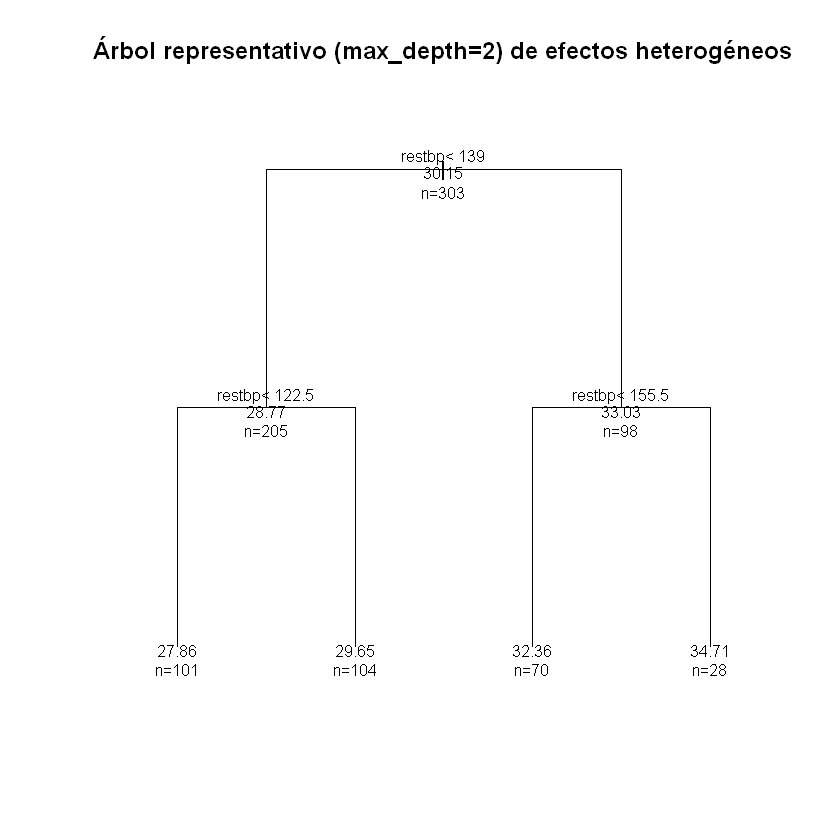

In [66]:
# Árbol representativo con max_depth=2
df_tree <- data.frame(
  tau = tau_hat,
  age = df$age,
  sex = df$sex,
  restbp = df$restbp,
  oldpeak = df$oldpeak
)

tree_model <- rpart(
  tau ~ age + sex + restbp + oldpeak,
  data = df_tree,
  control = rpart.control(maxdepth = 2, minsplit = 20, cp = 0.001)
)

png("C:/Decision_Trees/R/output/causal_forest_tree.png", 
    width = 1000, height = 600)
plot(tree_model, uniform = TRUE, margin = 0.1)
text(tree_model, use.n = TRUE, all = TRUE, cex = 0.8)
title("Árbol representativo (max_depth=2) de efectos heterogéneos")
dev.off()

plot(tree_model, uniform = TRUE, margin = 0.1)
text(tree_model, use.n = TRUE, all = TRUE, cex = 0.8)
title("Árbol representativo (max_depth=2) de efectos heterogéneos")

print(tree_model)

## Interpretación

El árbol muestra cómo el efecto estimado del tratamiento (es decir, cuánto mejora la salud cardiovascular promedio tras el programa) varía según la presión arterial en reposo (restbp). El modelo divide primero por la presión arterial, es decir que las personas con presión baja o normal (≤139 mmHg) presentan un efecto medio del tratamiento de aprox. 28.77, lo que indica una mejora moderada tras la intervención.

**Subgrupo izquierdo (restbp ≤ 122.5 mmHg)**

Entre quienes tienen la presión más baja, el efecto promedio cae a ≈27.86, lo que sugiere que el tratamiento tiene menor impacto en individuos con presión muy controlada o normal.

**Subgrupo derecho del nodo raíz (restbp > 139 mmHg)**

Los individuos con presión arterial elevada muestran efectos mucho más altos (≈33.03). Específicamente, aquellos con presión muy alta (restbp > 155.5) alcanzan el mayor efecto del tratamiento (≈34.71). Esto implica que el programa beneficia más a personas con hipertensión o presión en reposo alta, posiblemente porque estos pacientes parten de una peor condición cardiovascular y tienen mayor margen de mejora tras la intervención.

  feature importance
1  restbp 0.64576218
2     age 0.21171842
3 oldpeak 0.12587405
4     sex 0.01664535


png 
  2

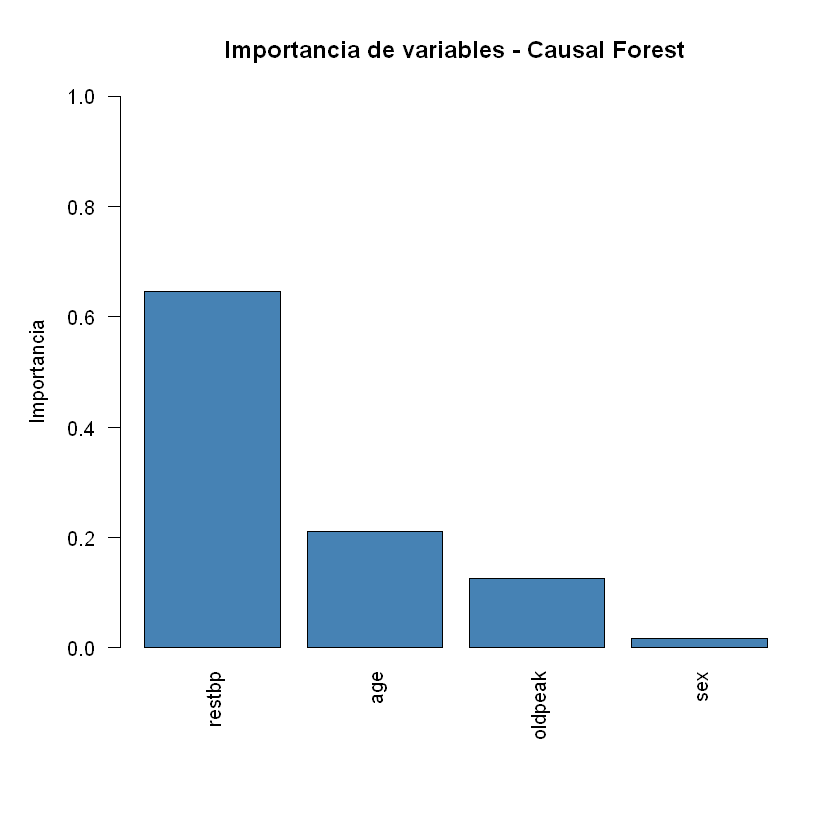

In [69]:
# Extraer importancias del Random Forest
importance_mat <- importance(rf_treat)
importances <- importance_mat[, "IncNodePurity"]

# Normalizar entre 0 y 1
importances <- importances / sum(importances)
importance_df <- data.frame(
  feature = names(importances),
  importance = importances,
  stringsAsFactors = FALSE
)

# Ordenar de mayor a menor
importance_df <- importance_df[order(-importance_df$importance), ]
rownames(importance_df) <- NULL
print(importance_df)

# Gráfico de barras
png("C:/Decision_Trees/R/output/cate_feature_importance.png", 
    width = 900, height = 500)
par(mar = c(8, 5, 4, 2))

barplot(importance_df$importance,
        names.arg = importance_df$feature,
        las = 2,
        col = "steelblue",
        main = "Importancia de variables - Causal Forest",
        ylab = "Importancia",
        ylim = c(0, 1))

dev.off()

# Mostrar en pantalla
par(mar = c(8, 5, 4, 2))
barplot(importance_df$importance,
        names.arg = importance_df$feature,
        las = 2,
        col = "steelblue",
        main = "Importancia de variables - Causal Forest",
        ylab = "Importancia",
        ylim = c(0, 1))

png 
  2

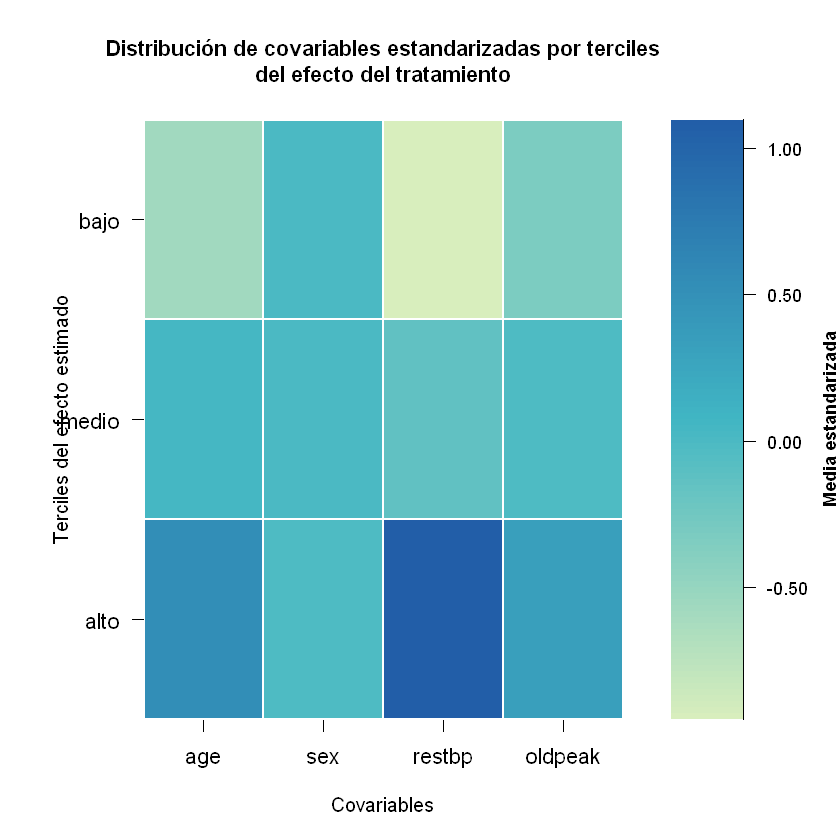

In [78]:
# Estandarizar covariables
X_std <- as.data.frame(scale(df[, X_vars]))
colnames(X_std) <- X_vars

# Dividir tau_hat en terciles
terciles <- quantile(tau_hat, probs = c(0, 1/3, 2/3, 1))
X_std$tercil_cate <- cut(tau_hat,
                         breaks = terciles,
                         labels = c("bajo", "medio", "alto"),
                         include.lowest = TRUE)

# Calcular media por tercil
mean_by_tercile <- aggregate(. ~ tercil_cate, data = X_std, FUN = mean)
rownames(mean_by_tercile) <- mean_by_tercile$tercil_cate
mean_by_tercile$tercil_cate <- NULL

# Reordenar niveles
mean_matrix <- as.matrix(mean_by_tercile[c("bajo", "medio", "alto"), ])

# Paleta de colores
color_palette <- colorRampPalette(c("#D8EEBD", "#41B6C4", "#225EA8"))(100)

# Plotear
plot_heatmap <- function() {
  layout(matrix(c(1, 2), ncol = 2), widths = c(4, 1))
  par(mar = c(5, 6, 5, 2))

  # Panel 1: Heatmap
  image(1:ncol(mean_matrix),
        1:nrow(mean_matrix),
        t(mean_matrix[nrow(mean_matrix):1, ]),
        col = color_palette,
        xlab = "Covariables",
        ylab = "Terciles del efecto estimado",
        main = "Distribución de covariables estandarizadas por terciles\ndel efecto del tratamiento",
        axes = FALSE,
        cex.main = 1.1)

  # Ejes
  axis(1, at = 1:ncol(mean_matrix), labels = colnames(mean_matrix), cex.axis = 1.1)
  axis(2, at = 1:nrow(mean_matrix), labels = rev(rownames(mean_matrix)), las = 1, cex.axis = 1.1)

  # Cuadrícula
  abline(v = seq(0.5, ncol(mean_matrix) + 0.5, 1), col = "white", lwd = 2)
  abline(h = seq(0.5, nrow(mean_matrix) + 0.5, 1), col = "white", lwd = 2)

  # Panel 2: Leyenda
  par(mar = c(5, 0, 5, 4))
  legend_vals <- seq(min(mean_matrix), max(mean_matrix), length.out = 100)
  image(x = 1, y = legend_vals, z = t(matrix(legend_vals)),
        col = color_palette, axes = FALSE, xlab = "", ylab = "")
  axis(4, at = pretty(legend_vals),
       labels = sprintf("%.2f", pretty(legend_vals)), las = 1, cex.axis = 0.9)
  mtext("Media estandarizada", side = 4, line = 3, font = 2, cex = 0.9)
}

plot_heatmap()

# Guardar
png("C:/Decision_Trees/R/output/cate_covariates_heatmap.png",
    width = 1000, height = 600)
plot_heatmap()
dev.off()
